# Project II - SciComp II
## N-Body Problem and Symplectic Integrators
> Author: Gil Miranda Neto<br>
> Contact: gilsmneto@gmail.com<br>
> Repo: [@mirandagil](https://github.com/mirandagil/university-courses/tree/master/comp-cientifica-II-2019-2/Project-II)<br>


---

Here is presented the numerical results of a study about the n-body problem and sympletic integrators.<br>
The numerical integrators used to solve the differential equation of orbital motion are:<br>

- Forward Euler (a non-sympletic first order method)
- Euler-Cromer (a sympletic first order method)
- Velocity-Verlet (a sympletic second order method - leapfrog)
- 4th order Yoshida Integrator (a sympletic fourth order method - leapfrog)

The results are presented here in a 3-D and a 2-D version.<br> Also an interactive version written in `Javascript` using the Yoshida method is presented at https://mirandagil.github.io/nbody <br>

In this notebook it's possible to see the orbits and a comparisson beteween the methods on the conservation of angular moment of the system, also the energy of the system.

---

#### Importing dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd

### The `Body` Class

In [2]:
class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color

    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of

    mass = 0
    v_x = v_y = v_x0 = v_y0 = v_z = v_z0 = 0
    p_x = p_y = p_x0 = p_y0 = p_z = p_z0 = 0
    pos_x = []
    pos_y = []
    pos_z = []
    angle = 0
    kinetic = 0
    potential = 0
    ang_mo = 0

    def acceleration(self, bodies, pos = [0,0,0], retpe = False, G = 6.67428e-11, retm = False):
        acc_x = acc_y = acc_z = 0
        pe = 0
        m = 0
        for other in bodies:
            if self is other:
                continue
            d_x = (other.p_x - pos[0])
            d_y = (other.p_y - pos[1])
            d_z = (other.p_z - pos[2])
            d = np.sqrt(d_x**2 + d_y**2 + d_z**2) ## Calculate the distance between the bodies
            if d == 0:
                raise ValueError('The bodies %r and %r collided' %(self.name, other.name))

            ## Compute acceleration OTHER causes on THIS
            a_x = -G * other.mass * pos[0] / d**3
            a_y = -G * other.mass * pos[1] / d**3
            a_z = -G * other.mass * pos[2] / d**3

            if retm:
                v = self.v_x**2 + self.v_y**2 #v^2
                dsun = (self.p_x**2 + self.p_y**2)
                try:
                    m += np.sqrt(dsun * (self.mass**2 * v) - (self.p_x * self.v_x * self.mass + self.mass * self.p_y * self.v_y)**2)
                except:
                    m += 0

            ## Compute potential Energy
            if retpe:
                pe += G * other.mass * self.mass / d
            acc_x += a_x
            acc_y += a_y
            acc_z += a_z

        if retpe and retm:
            return acc_x, acc_y, acc_z, pe, m
        else:
            return acc_x, acc_y, acc_z


### Physics and plotting functions

In [3]:
AU = (149.6e9)

def simulate(bodies, step = 3600, period = 365, method = 'euler', G = 6.67428e-11):
    count = 0
    pos = {}
    vel_sq = {}
    potential = {}
    ang_mo = {}
    for body in bodies:
        pos[body.name] = []
        vel_sq[body.name] = []
        potential[body.name] = []
        ang_mo[body.name] = []
        ## Routine that resets body position state in each simulation
        body.p_x = body.p_x0
        body.p_y = body.p_y0
        body.p_z = body.p_z0
        body.v_x = body.v_x0
        body.v_y = body.v_y0
        body.v_z = body.v_z0

    while count < period:
        acc = {}
        for body in bodies:
            acc_x = acc_y = acc_z = 0
            for other in bodies:
                if body is other:
                    continue
                acc_x, acc_y, acc_z, body.potential, body.ang_mo = body.acceleration(bodies, pos = [body.p_x, body.p_y, body.p_z], retm = True, retpe = True, G = G)
                acc[body] = (acc_x, acc_y, acc_z)

        for body in bodies:
            pos[body.name].append((body.p_x,body.p_y, body.p_z))
            vel_sq[body.name].append((body.v_x**2 + body.v_y**2 + body.v_z**2))
            potential[body.name].append(body.potential)
            ang_mo[body.name].append(body.ang_mo)

            a_x, a_y, a_z = acc[body]

            if method == 'euler-cromer':
            ## Sympletic 1st-order Euler
                body.v_x += a_x * step
                body.v_y += a_y * step
                body.v_z += a_z * step
                
                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                body.p_z += body.v_z * step
            
            elif method == 'velocity-verlet':
            ## Velocity Verlet / Leapfrog - Sympletic 2nd-order methods
                vhalf_x = body.v_x + 0.5 * step * a_x
                vhalf_y = body.v_y + 0.5 * step * a_y
                vhalf_z = body.v_z + 0.5 * step * a_z
 
                body.p_x += vhalf_x * step
                body.p_y += vhalf_y * step
                body.p_z += vhalf_z * step

                ax_new, ay_new, az_new = body.acceleration(bodies, pos = [body.p_x, body.p_y, body.p_z], G = G)

                body.v_x = vhalf_x + ax_new * 0.5 * step
                body.v_y = vhalf_y + ay_new * 0.5 * step
                body.v_z = vhalf_z + az_new * 0.5 * step

            elif method == 'position-verlet':
            ## Velocity Verlet / Leapfrog - Sympletic 2nd-order methods
                phalf_x = body.p_x +  0.5 * step * body.v_x
                phalf_y = body.p_y +  0.5 * step * body.v_y
                phalf_z = body.p_z + 0.5 * step * body.v_z

                ax_new, ay_new, az_new = body.acceleration(bodies, pos = [phalf_x, phalf_y, phalf_z], G = G)

                body.v_x += ax_new * step
                body.v_y += ay_new * step
                body.v_z += az_new * step

                body.p_x = phalf_x + body.v_x * step/2
                body.p_y = phalf_y + body.v_y * step/2
                body.p_z = phalf_z + body.v_z * step/2

            elif method == 'yoshida':
                w = 1.2599210498948732 # 2**(1./3.)
                f = 0.7400789501051268 # 2 - w

                lf1 = (0.5 * step / f)
                p1_x = body.p_x + lf1 * body.v_x
                p1_y = body.p_y + lf1 * body.v_y
                p1_z = body.p_z + lf1 * body.v_z

                ax_new, ay_new, az_new = body.acceleration(bodies, pos = [p1_x, p1_y, p1_z], G = G)

                lf2 = step / f
                v2_x = body.v_x + lf2 * ax_new
                v2_y = body.v_y + lf2 * ay_new
                v2_z = body.v_z + lf2 * az_new
                
                lf3 = (1 - w) * step * 0.5 / f
                p3_x = p1_x + lf3 * v2_x
                p3_y = p1_y + lf3 * v2_y
                p3_z = p1_z + lf3 * v2_z

                ax_new, ay_new, az_new = body.acceleration(bodies, pos = [p3_x, p3_y, p3_z], G = G)

                lf4 = -step * w / f
                v4_x = v2_x + lf4 * ax_new
                v4_y = v2_y + lf4 * ay_new
                v4_z = v2_z + lf4 * az_new

                p5_x = p3_x + lf3 * v4_x
                p5_y = p3_y + lf3 * v4_y
                p5_z = p3_z + lf3 * v4_z

                ax_new, ay_new, az_new = body.acceleration(bodies, pos = [p5_x, p5_y, p5_z], G = G)

                body.v_x = v4_x + lf2 * ax_new
                body.v_y = v4_y + lf2 * ay_new
                body.v_z = v4_z + lf2 * az_new

                body.p_x = p5_x + lf1 * body.v_x
                body.p_y = p5_y + lf1 * body.v_y
                body.p_z = p5_z + lf1 * body.v_z 

            else:
            ## 1st-order Euler
                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                body.p_z += body.v_z * step

                body.v_x += a_x * step
                body.v_y += a_y * step
                body.v_z += a_z * step
        count += 1
    return pos, vel_sq, potential, ang_mo

def momentum_calc(bodies, methods, hs, vel_vec, t):
    momentum = {}
    for m in methods:
        momentum[m] = []
        for h in range(0,len(hs)):
            mom = np.array([0.0]*t)
            for b in bodies:
                mom += vel_vec[m][h][1][b.name]
            mom = mom / 2
            momentum[m].append((h, mom))
    return momentum

def ang_mo_calc(bodies, methods, hs, mo_vec, t):
    ang_mo = {}
    for m in methods:
        ang_mo[m] = []
        for h in range(0,len(hs)):
            mo = np.array([0.0]*t)
            for b in bodies:
                mo += mo_vec[m][h][1][b.name]
            mo = mo / 2
            ang_mo[m].append((h, mo))
    return ang_mo

def potential_calc(bodies, methods, hs, pot_vec, t):
    potential = {}
    for m in methods:
        potential[m] = []
        for h in range(0,len(hs)):
            pot = np.array([0.0]*t)
            for b in bodies:
                pot += pot_vec[m][h][1][b.name]
            pot = pot / 2
            potential[m].append((h, pot))
    return potential

def orbit_plotter(pos, bodies, title = 'Orbits', scale = False, color = False):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]

    plt.figure(figsize=(10,10))

    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)

    plt.legend()
    plt.grid(alpha=0.2)


    ax = plt.gca()
    if color:
        ax.set_facecolor('black')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:.2f}'.format(x/AU))
    ax.xaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_formatter(ticks)
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')

    plt.title(title)
    plt.show()
    return ax

def big_simulation(methods = ['euler'], steps = [3600], t = 1000, bod = 0, G = 6.67428e-11):
    pos = {}
    vel = {}
    energy = {}
    ang_mo = {}
    for m in methods:
        pos[m] = []
        vel[m] = []
        energy[m] = []
        ang_mo[m] = []
        for h in steps:
            ret_pos, ret_vel, ret_energy, ret_ang = simulate(bod, period = t, method = m, step = h, G = G)
            pos[m].append([h, ret_pos])
            vel[m].append([h, ret_vel])
            energy[m].append([h, ret_energy])
            ang_mo[m].append([h, ret_ang])
    return pos, vel, energy, ang_mo



def big_plotter(methods = ['euler'], t = 100, steps = [3600], graph = ['orbit'], opt = ['bodies', 'The Solar System'], pos_vec = [0], u_vec = [0], p_vec = [0], ang_vec = [0]):
    ts = np.linspace(0,t,t)
    for m in methods:
        if 'orbit' in graph:
                j = 0
                for h in steps:
                    orbit_plotter(pos_vec[m][j][1], opt[0], title = opt[1] + ' - ' + m + ' - h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days')
                    j += 1

        if 'hamilton' in graph:
            plt.figure(figsize=(12,8))
            i = 0
            for h in steps:
                H = p_vec[m][i][1] - u_vec[m][i][1]
                plt.plot(ts, H, label = 'h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days -> '+ ' $\Delta = $ '+ '{0:.3f}'.format(((max(H)-min(H))/min(H))*100) + '%')
                i += 1
            plt.title('Hamiltoniano - '+ m)
            plt.xlabel('Periods')
            plt.ylabel('Hamiltonian')
            plt.legend(loc = 1)
            plt.grid(alpha = 0.5)
            plt.show()

        if 'momentum' in graph:
            plt.figure(figsize=(12,8))
            i = 0
            for h in steps:
                plt.plot(ts, ang_vec[m][i][1], label = 'h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days -> '+ ' $\Delta = $ '+ '{0:.6f}'.format(((max(ang_vec[m][i][1])-min(ang_vec[m][i][1]))/min(ang_vec[m][i][1]))*100) + '%')
                i += 1
            plt.title('Angular Momentum - '+ m)
            plt.xlabel('Periods')
            plt.ylabel('Angular Momentum')
            plt.legend(loc = 1)
            plt.grid(alpha = 0.5)
            plt.show()

            
def orbit_plotter3D(pos, bodies, title = 'Orbits', scale = False, color = False, azim = 0, elev = 0):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
        b.pos_z = [i[2] for i in pos[b.name]]

    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    
    for b in bodies:
        if(azim != 0 and elev !=0):
            ax.view_init(elev=elev, azim=azim)
        ax.plot3D(b.pos_x, b.pos_y, b.pos_z, label = b.name, color = b.color, linestyle=':')
        ax.scatter3D(b.pos_x[-1],b.pos_y[-1], b.pos_z[-1], color = b.color)
    plt.legend()
    plt.grid(alpha=0.2)


    ax = plt.gca()
    if color:
        ax.set_facecolor('black')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:.2f}'.format(x/AU))
    ax.xaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_formatter(ticks)
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')

    plt.title(title)
    plt.show()
    return ax

def big_plotter3D(methods = ['euler'], t = 100, steps = [3600], graph = ['orbit'], opt = ['bodies', 'The Solar System'], pos_vec = [0], u_vec = [0], p_vec = [0], ang_vec = [0]):
    ts = np.linspace(0,t,t)
    for m in methods:
        if 'orbit' in graph:
                j = 0
                for h in steps:
                    orbit_plotter3D(pos_vec[m][j][1], opt[0], title = opt[1] + ' - ' + m + ' - h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days')
                    orbit_plotter3D(pos_vec[m][j][1], opt[0], title = opt[1] + ' - ' + m + ' - h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days', elev = 30, azim = 70)
                    j += 1

        if 'hamilton' in graph:
            plt.figure(figsize=(12,8))
            i = 0
            for h in steps:
                H = p_vec[m][i][1] - u_vec[m][i][1]
                plt.plot(ts, H, label = 'h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days -> '+ ' $\Delta = $ '+ '{0:.3f}'.format(((max(H)-min(H))/min(H))*100) + '%')
                i += 1
            plt.title('Hamiltoniano - '+ m)
            plt.xlabel('Periods')
            plt.ylabel('Hamiltonian')
            plt.legend(loc = 1)
            plt.grid(alpha = 0.5)
            plt.show()

        if 'momentum' in graph:
            plt.figure(figsize=(12,8))
            i = 0
            for h in steps:
                plt.plot(ts, ang_vec[m][i][1], label = 'h = ' + '{0:.2f}'.format(h/(3600*24)) + ' days -> '+ ' $\Delta = $ '+ '{0:.6f}'.format(((max(ang_vec[m][i][1])-min(ang_vec[m][i][1]))/min(ang_vec[m][i][1]))*100) + '%')
                i += 1
            plt.title('Angular Momentum - '+ m)
            plt.xlabel('Periods')
            plt.ylabel('Angular Momentum')
            plt.legend(loc = 1)
            plt.grid(alpha = 0.5)
            plt.show()

### Initializing the celestial bodies
#### Setting Initial Values
Data gathered from: https://nssdc.gsfc.nasa.gov/planetary/factsheet/

In [4]:
sun = Body('Sun', 'yellow')
sun.mass = 1.98855e30
sun.size = 20

earth = Body('Earth', 'darkblue')
earth.mass = 5.9742e24
earth.p_x0 = 147.1e9
earth.v_y0 = 30.29e3
earth.size = 1
earth.angle = 1.07 * np.pi/180
earth.p_z0 = np.sin(earth.angle)*earth.p_x0

venus = Body('Venus', 'salmon')
venus.mass = 4.8685e24
venus.p_x0 = 107.5e9
venus.v_y0 = -35.26e3
venus.angle = 1.2 * np.pi/180
venus.p_z0 = np.sin(venus.angle)*venus.p_x0
venus.size = 0.95
    
mercury = Body('Mercury', 'darkmagenta')
mercury.mass = 0.3e24
mercury.p_x0 = 46e9
mercury.v_y0 = 58.98e3
mercury.size = 0.38
mercury.angle = 1.8 * np.pi/180
mercury.p_z0 = np.sin(mercury.angle)*mercury.p_x0

mars = Body('Mars', 'r')
mars.mass = 0.642e24
mars.p_x0 = 206.6e9
mars.v_y0 = 26.5e3
mars.size = 0.53
mars.angle = 1.07 * np.pi/180
mars.p_z0 = np.sin(mars.angle)*mars.p_x0
    
jupiter = Body('Jupiter', 'orangered')
jupiter.mass = 1.898e27
jupiter.p_x0 = 740.5e9
jupiter.v_y0 = 13.72e3
jupiter.size = 11.2
jupiter.angle = 0.5 * np.pi/180
jupiter.p_z0 = np.sin(jupiter.angle)*jupiter.p_x0

saturn = Body('Saturn', 'maroon')
saturn.mass = 5.68e26
saturn.p_x0 = 1352.6e9
saturn.v_y0 = 10.18e3
saturn.size = 9.45
saturn.angle = 0.93 * np.pi / 180
saturn.p_z0 = np.sin(saturn.angle)*saturn.p_x0
    
uranus = Body('Uranus', 'darkgreen')
uranus.mass = 8.6e25
uranus.p_x0 = 2741.3e9
uranus.v_y0 = 7.11e3
uranus.size = 4
uranus.angle = 1.02 * np.pi/180
uranus.p_z0 = np.sin(uranus.angle)*uranus.p_x0

neptune = Body('Neptune', 'navy')
neptune.mass = 1.02e26
neptune.p_x0 = 4444.5e9
neptune.v_y0 = 5.5e3
neptune.size = 3.8
neptune.angle = 0.72 * np.pi/180    
neptune.p_z0 = np.sin(neptune.angle)*neptune.p_x0

---
### List with bodies object

Separated in
- Full solar system: All 8 planets;
- Inner Solar System: Mercury, Venus, Earth, Mars
- Inner + Jupiter;
- Outter Solar System: Jupiter, Saturn, Uranus, Neptune

In [5]:
bodies = [sun, mercury, venus, earth, mars, jupiter, saturn, neptune, uranus] ## full system
bodies_jp = [sun, earth, venus, mars, mercury, jupiter] ## Inner planets + Jupiter
bodies_inner = [sun, earth, venus, mars, mercury] ## Inner Planets
bodies_outter = [sun, jupiter, saturn, uranus, neptune] ## Outer Planets

bodies_test = bodies_inner#[sun, mercury, venus, earth, mars, jupiter, ]

---
### Setting List with the timesteps and methods to simulate
The time step is measured in seconds, so $h = 3600$ is read as 1 hour step<br>
Period is how much times the simulation will take place

In [6]:
hs = [3600*24]
m = ['yoshida', 'velocity-verlet', 'euler']
period = 3000

### Running Simulation #1

In [7]:
pos, vel, pot, ang_mo = big_simulation(methods = m, t = period, steps = hs, bod = bodies)

### Plotting Inner Orbits

We expect error on the euler method, because it does not conserves system energy.

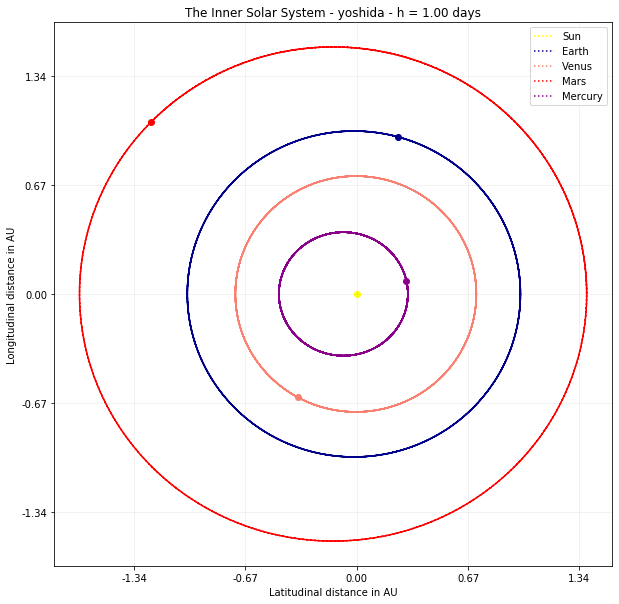

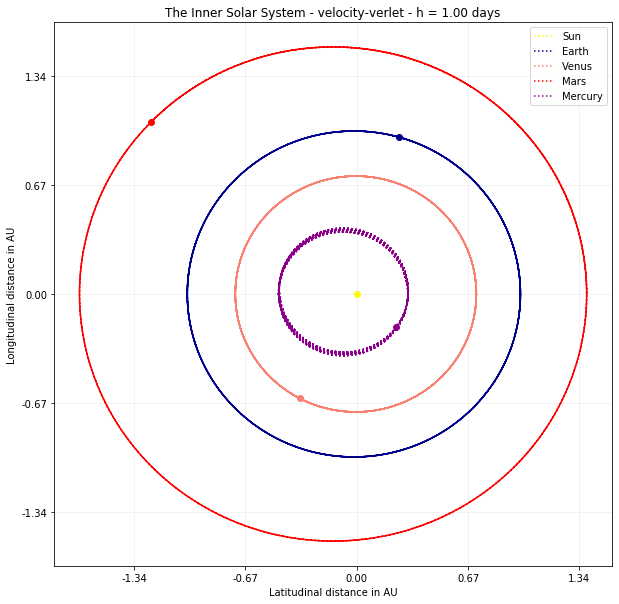

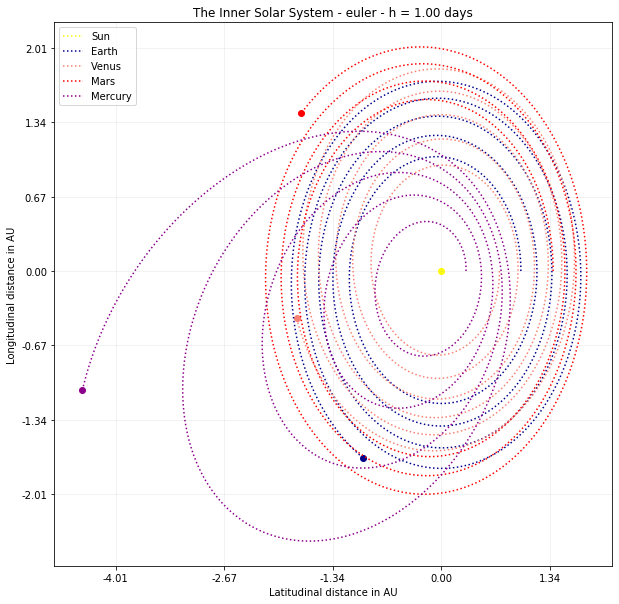

In [8]:
big_plotter(methods = m, steps = hs, graph = ['orbit'], opt = [bodies_inner, 'The Inner Solar System'], pos_vec = pos)

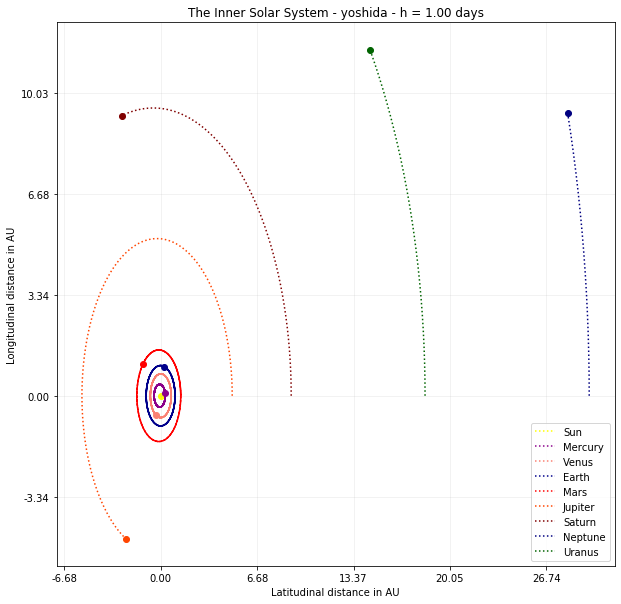

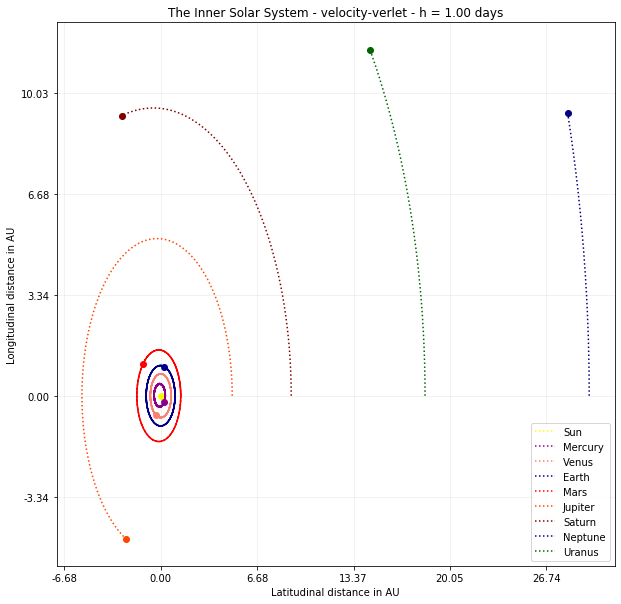

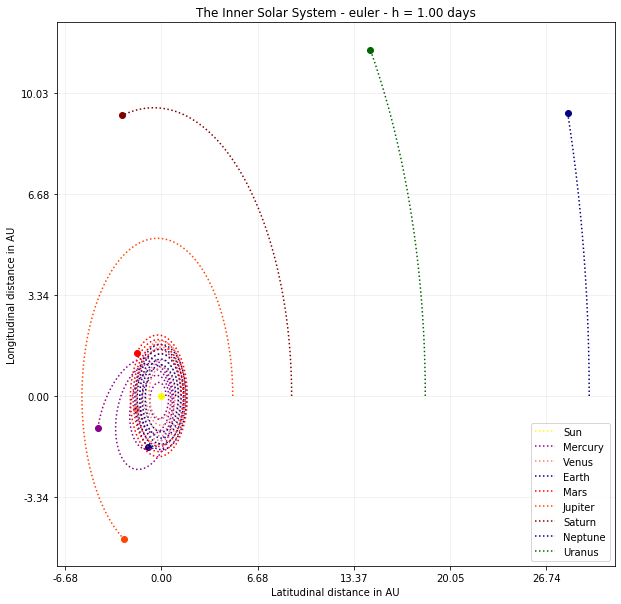

In [9]:
big_plotter(methods = m, steps = hs, graph = ['orbit'], opt = [bodies, 'The Inner Solar System'], pos_vec = pos)

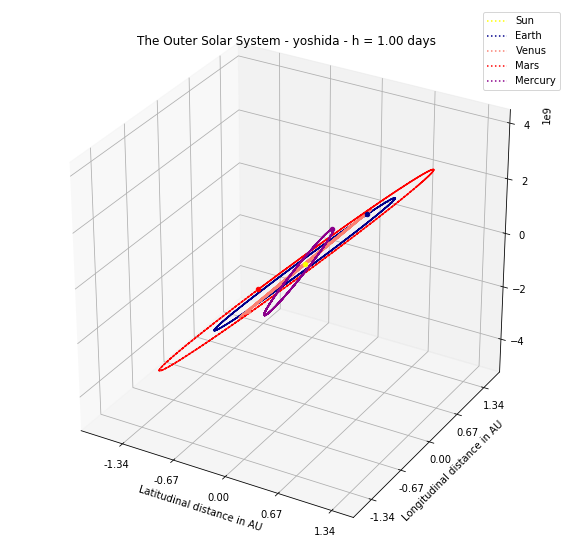

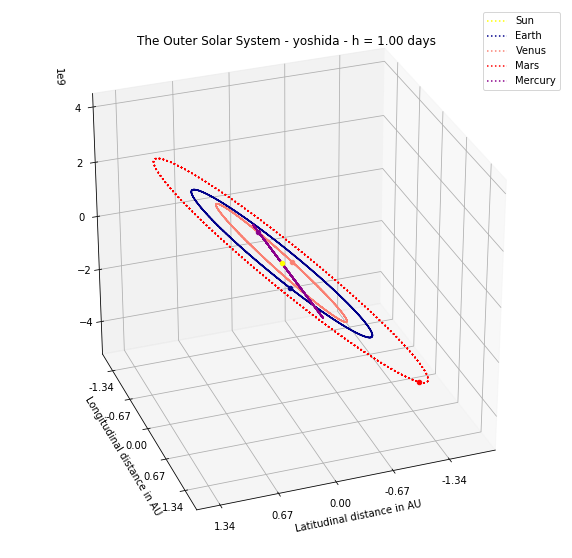

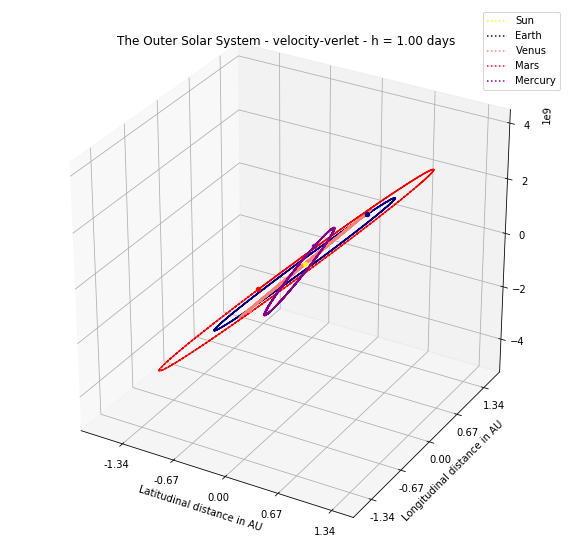

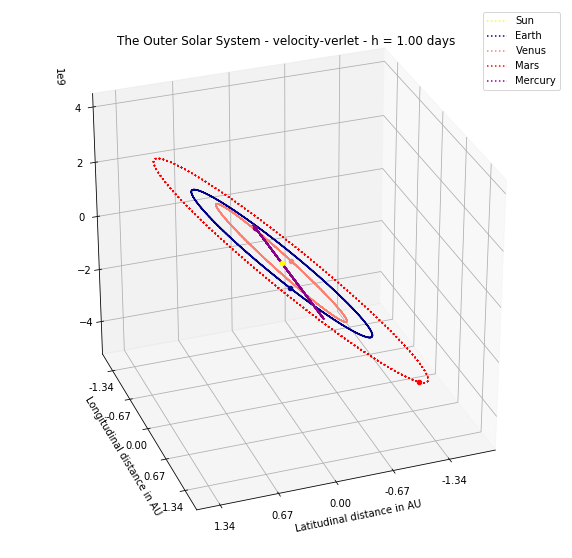

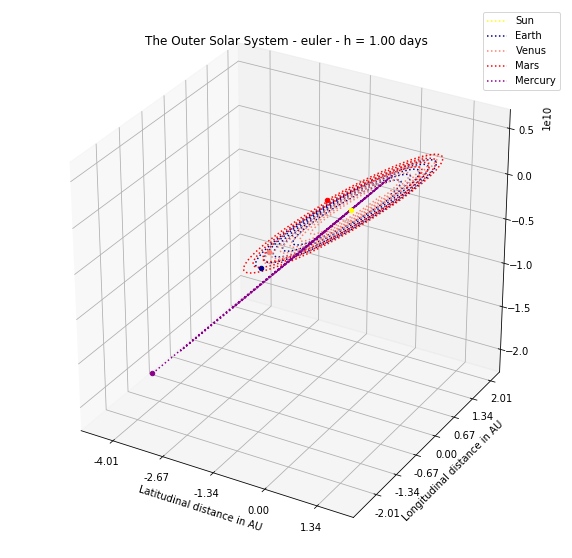

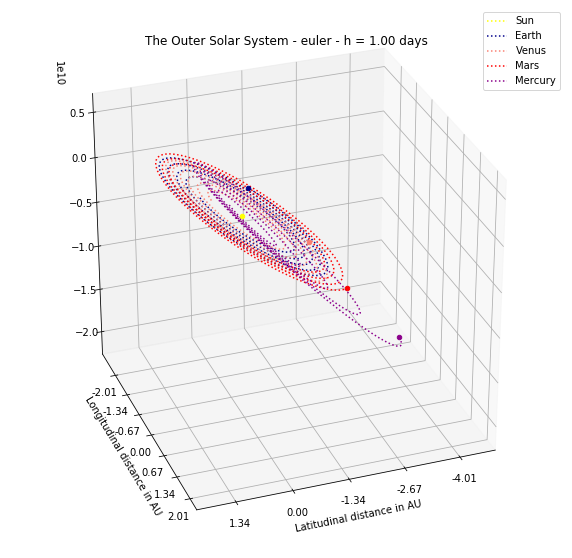

In [10]:
big_plotter3D(methods = m, steps = hs, graph = ['orbit'], opt = [bodies_test, 'The Outer Solar System'], pos_vec = pos)

### Energy of the system

In [11]:
momentum_p = momentum_calc(bodies_test, methods = m, hs = hs, vel_vec = vel, t = period)
potential_u = potential_calc(bodies_test, methods = m, hs = hs, pot_vec = pot, t = period)
angular_m = ang_mo_calc(bodies_test, methods = m, hs = hs, mo_vec = ang_mo, t = period)

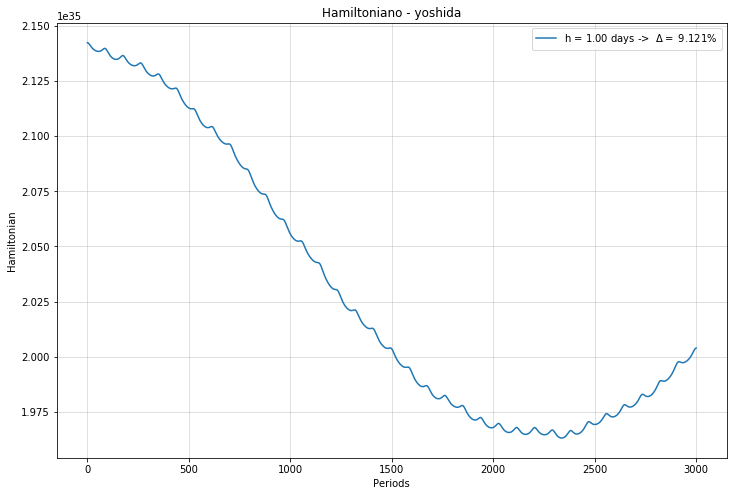

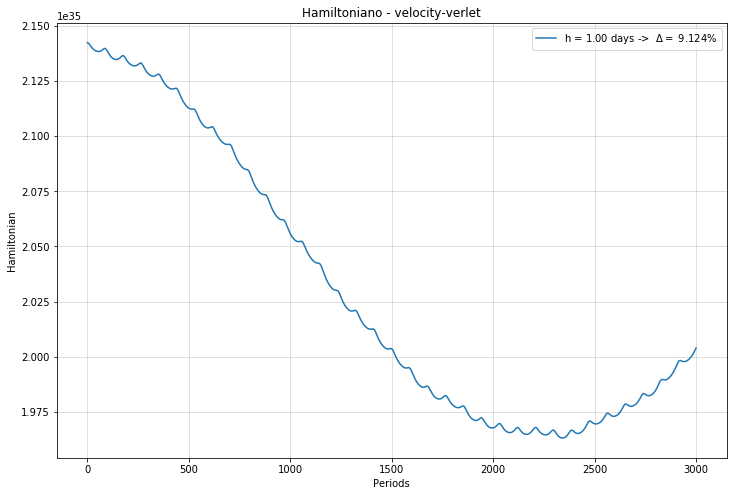

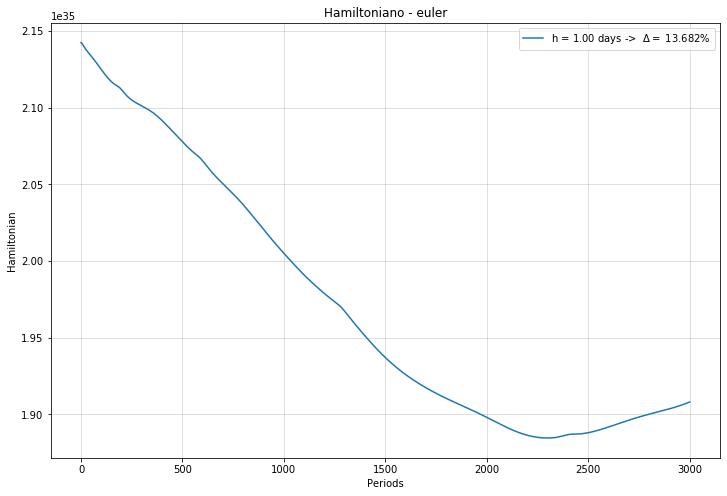

In [12]:
big_plotter(methods = m, t = period, steps = hs, graph = ['hamilton'], opt = [bodies, 'The Inner Solar System'], pos_vec = pos, p_vec = potential_u, u_vec = momentum_p)

## Angular Momentum of the system

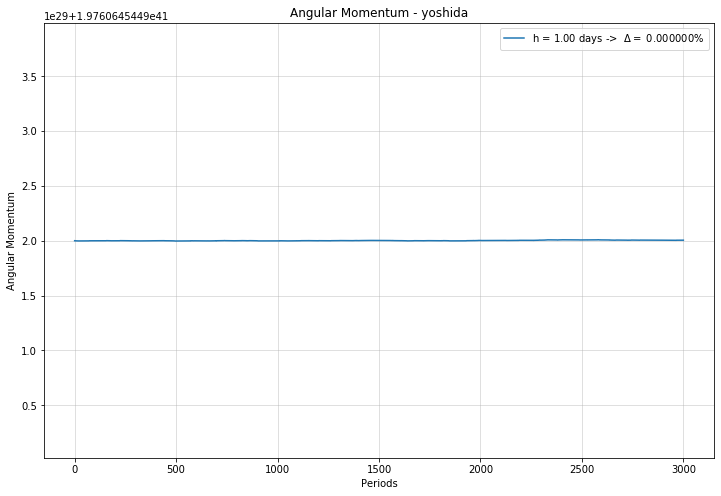

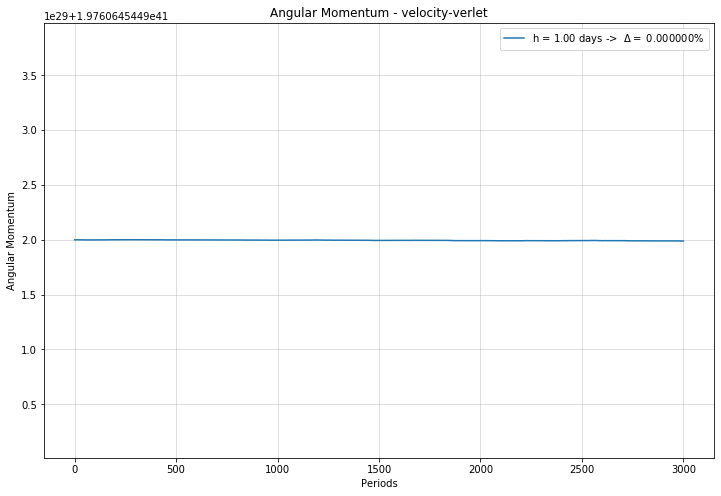

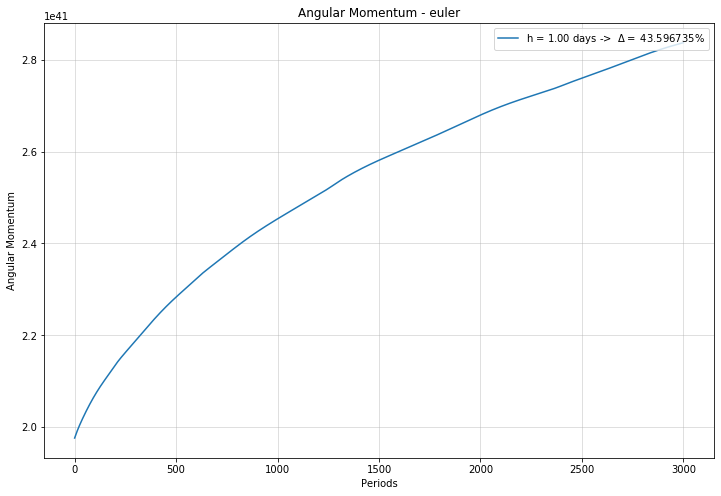

In [13]:
big_plotter(methods = m, t = period, steps = hs, graph = ['momentum'], opt = [bodies, 'The Inner Solar System'], pos_vec = pos, ang_vec = angular_m)

## Verifying the model

## Kepler Laws

We can check if our method is any good by testing Kepler's Law of Planetary Motion for our model<br>
All verification will be made with 


### First Law
1. `The orbit of every planet is an ellipse with the Sun at one of the two foci.`<br> <br> 
We will check the eccentricity of the orbits in our model and compare them with data from `NASA`

In [14]:
## data from: https://nssdc.gsfc.nasa.gov/planetary/factsheet/
data = {}
data['eccentricity'] = {'Mercury': 0.205, 'Venus': 0.007, 'Earth': 0.017, 'Mars':0.094, 'Jupiter': 0.049, 'Saturn': 0.057, 'Neptune': 0.011, 'Uranus': 0.046}

In [15]:
def calc_aphelion(pos):
    aphelion = 0
    for i in pos:
        dist = np.sqrt(i[0]**2+i[1]**2 + i[2]**2)
        if dist > aphelion: aphelion = dist
    return aphelion

def calc_perihelion(pos):
    pherihelion = 50*152e9
    for i in pos:
        dist = np.sqrt(i[0]**2+i[1]**2+i[2]**2)
        if dist < pherihelion: pherihelion = dist
    return pherihelion

def calc_ecc(ap, pe):
    e = 1-(2/((ap/pe)+1))
    return e

aphelion = {}
perihelion = {}

for b in bodies[1:]:
    #aphelion[b.name] = calc_aphelion(pos['velocity-verlet'][0][1][b.name])
    #perihelion[b.name] = calc_perihelion(pos['velocity-verlet'][0][1][b.name])
    aphelion[b.name] = calc_aphelion(pos['yoshida'][0][1][b.name])
    perihelion[b.name] = calc_perihelion(pos['yoshida'][0][1][b.name])
    
eccentricity = {}

for b in bodies[1:]:
    eccentricity[b.name] = calc_ecc(aphelion[b.name], perihelion[b.name])

In [16]:
# data_plot = [[data['eccentricity']['Mercury'],0], [eccentricity['Mercury'],2]]
error = [abs(i-j)/i for i,j in zip(data['eccentricity'].values(),eccentricity.values())]
ecc_error = {}
for (b,e) in zip(bodies[1:],error):
    ecc_error[b.name] = e
pd.DataFrame([data['eccentricity'],eccentricity,ecc_error],['NASA','Yoshida', 'Error (%)'])

,Mercury,Venus,Earth,Mars,Jupiter,Saturn,Neptune,Uranus
NASA,0.205000,0.007000,0.017000,0.094000,0.049000,0.057000,0.011000,0.046000
Yoshida,0.206274,0.007253,0.017039,0.093290,0.050128,0.033172,0.000267,0.004270
Error (%),0.006213,0.036082,0.002279,0.007553,0.023010,0.418032,0.975705,0.907164


So our Yoshida 4th order integrator makes only a $0.05\%$ max error on the eccentricity of the orbits